The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import time as time

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL

#
from ib_functions_ml import *

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in four pieces. 

In [2]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

#renaming columns
dic1={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'}
real_power1.rename(columns=dic1,inplace=True)
real_power2.rename(columns=dic1,inplace=True)
real_power3.rename(columns=dic1,inplace=True)
real_power4.rename(columns=dic1,inplace=True)
#different rename for newest data frame needed
dic2={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
real_power5.rename(columns=dic2,inplace=True)
#drop columns
real_power5.drop(['Ende'], axis=1, inplace=True)
#cpnvert german float to english 
real_power5['residual_power'] = real_power5['residual_power'].str.replace('.','')
real_power5['residual_power'] = real_power5['residual_power'].str.replace(',','.').astype(float)/1000.
real_power5['total_power'] = real_power5['total_power'].str.replace('.','')
real_power5['total_power'] = real_power5['total_power'].str.replace(',','.').astype(float)/1000.
real_power5['pump_storage'] = real_power5['pump_storage'].str.replace('.','')
real_power5['pump_storage'] = real_power5['pump_storage'].str.replace(',','.').astype(float)/1000.
#get real date time 
real_power1['date_time']=pd.to_datetime(real_power1['Date'] + '.' + real_power1['Time'], format='%d.%m.%Y.%H:%M')
real_power2['date_time']=pd.to_datetime(real_power2['Date'] + '.' + real_power2['Time'], format='%d.%m.%Y.%H:%M')
real_power3['date_time']=pd.to_datetime(real_power3['Date'] + '.' + real_power3['Time'], format='%d.%m.%Y.%H:%M')
real_power4['date_time']=pd.to_datetime(real_power4['Date'] + '.' + real_power4['Time'], format='%d.%m.%Y.%H:%M')
real_power5['date_time']=pd.to_datetime(real_power5['Date'] + '.' + real_power5['Time'], format='%d.%m.%Y.%H:%M')
#date_time is set to index
real_power1=real_power1.set_index('date_time')
real_power2=real_power2.set_index('date_time')
real_power3=real_power3.set_index('date_time')
real_power4=real_power4.set_index('date_time')
real_power5=real_power5.set_index('date_time')
#combining with concat
comb_real_power=pd.concat([real_power4,real_power3,real_power2,real_power1,real_power5])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()

/tmp/ipykernel_2858/3889048620.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_power5['residual_power'] = real_power5['residual_power'].str.replace('.','')
/tmp/ipykernel_2858/3889048620.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_power5['total_power'] = real_power5['total_power'].str.replace('.','')
/tmp/ipykernel_2858/3889048620.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_power5['pump_storage'] = real_power5['pump_storage'].str.replace('.','')


(18604.0, 18611.0)

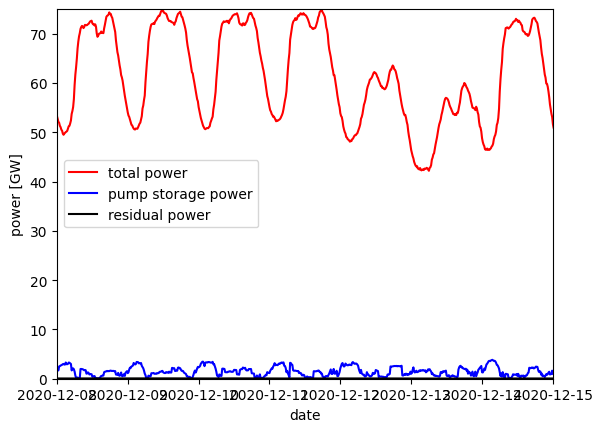

In [12]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0,75)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))

In [3]:
#freeing space
size_1=real_power1.shape[0]
size_2=real_power2.shape[0]
size_3=real_power3.shape[0]
size_4=real_power4.shape[0]
size_5=real_power5.shape[0]
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0
#Now getting the offical predictions. 
pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')
dic1b={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power_pred','Residuallast[MWh]':'residual_power_pred'}
pred_power1.rename(columns=dic1b,inplace=True)
#here most different because onlyn now gotten
dic2b={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power_pred','Residuallast [MWh] Originalauflösungen':'residual_power_pred','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
pred_power2.rename(columns=dic2b,inplace=True)
pred_power3.rename(columns=dic2b,inplace=True)
pred_power4.rename(columns=dic2b,inplace=True)
pred_power5.rename(columns=dic2b,inplace=True)
#drop columns
pred_power2.drop(['Ende'], axis=1, inplace=True)
pred_power3.drop(['Ende'], axis=1, inplace=True)
pred_power4.drop(['Ende'], axis=1, inplace=True)
pred_power5.drop(['Ende'], axis=1, inplace=True)

#some are - no data I assume, thus not all can be used 
pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power3['residual_power_pred'] = pred_power3['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power3['residual_power_pred'] = pred_power3['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power3['total_power_pred'] = pred_power3['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power3['total_power_pred'] = pred_power3['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power4['residual_power_pred'] = pred_power4['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power4['residual_power_pred'] = pred_power4['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power4['total_power_pred'] = pred_power4['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power4['total_power_pred'] = pred_power4['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power5['residual_power_pred'] = pred_power5['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power5['residual_power_pred'] = pred_power5['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power5['total_power_pred'] = pred_power5['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power5['total_power_pred'] = pred_power5['total_power_pred'].str.replace(',','.').astype(float)/1000.

pred_power1['date_time']=pd.to_datetime(pred_power1['Date'] + '.' + pred_power1['Time'], format='%d.%m.%Y.%H:%M')
pred_power2['date_time']=pd.to_datetime(pred_power2['Date'] + '.' + pred_power2['Time'], format='%d.%m.%Y.%H:%M')
pred_power3['date_time']=pd.to_datetime(pred_power3['Date'] + '.' + pred_power3['Time'], format='%d.%m.%Y.%H:%M')
pred_power4['date_time']=pd.to_datetime(pred_power4['Date'] + '.' + pred_power4['Time'], format='%d.%m.%Y.%H:%M')
pred_power5['date_time']=pd.to_datetime(pred_power5['Date'] + '.' + pred_power5['Time'], format='%d.%m.%Y.%H:%M')

#date_time is set to index
pred_power1=pred_power1.set_index('date_time')
pred_power2=pred_power2.set_index('date_time')
pred_power3=pred_power3.set_index('date_time')
pred_power4=pred_power4.set_index('date_time')
pred_power5=pred_power5.set_index('date_time')
#combining with concat
comb_pred_power=pd.concat([pred_power4,pred_power3,pred_power2,pred_power1,pred_power5])
#reset index for easier handling
comb_pred_power=comb_pred_power.reset_index()

comb_real_power.loc[0:comb_pred_power.shape[0],['total_power_pred','residual_power_pred']]=comb_pred_power.loc[:,['total_power_pred','residual_power_pred']]
#free storage
pred_power1=0
pred_power2=0
pred_power3=0
pred_power4=0
pred_power5=0
comb_pred_power=0

/tmp/ipykernel_2858/1373102549.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace('.','').str.replace('-','0')
/tmp/ipykernel_2858/1373102549.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace('.','').str.replace('-','0')
/tmp/ipykernel_2858/1373102549.py:37: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power3['residual_power_pred'] = pred_power3['resi

In [4]:
time1=np.zeros((comb_real_power.shape[0],5))
for i in range(comb_real_power.shape[0]):
    time1[i,0]=i/4/24
    time1[i,1]=time1[i,0]%1
    time1[i,2]=(time1[i,0]%7)/7
    time1[i,3]=(time1[i,0]%365.25)/365.25
    time1[i,4]=i/4/24/365.25      
comb_real_power['frac_day']=time1[:,1]
comb_real_power['frac_week']=time1[:,2]
comb_real_power['frac_year']=time1[:,3]

#later also real daya and easter but for now just using the current model to predict

In [5]:
myPath='/home/tobias/ml-testing/energy/energy-timeseries'
models=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb_model_')) and  (f.endswith('json') )] 
models.sort()


total_power    11.72175
frac_day       0.989583
frac_week      0.855655
frac_year      0.004763
Name: 315743, dtype: object


In [6]:
prediction=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741     12.09550  0.968750   0.852679   0.004706
315742     11.83150  0.979167   0.854167   0.004734
315743     11.72175  0.989583   0.855655   0.004763
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [7]:
prediction2=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0]-2,['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741      12.0955  0.968750   0.852679   0.004706
315742      11.8315  0.979167   0.854167   0.004734
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


Seems to work and relatively fast, likely fats enough for doing it every 15 mimnutes.
Not crazy fast but good enough for now. 

In [21]:
pred_df=pd.DataFrame(prediction.T,columns=['hours','consumption','error'])
print(pred_df)
for i in range(pred_df.shape[0]):
    pred_df.loc[i,'date_time']=comb_real_power.loc[comb_real_power.shape[0]-1,'date_time']+timedelta(hours=pred_df['hours'][i])
print(pred_df)

     hours  consumption  error
0     0.25    11.576932    0.0
1     0.50    11.470897    0.0
2     0.75    11.304346    0.0
3     1.00    11.215144    0.0
4     1.25    11.058895    0.0
..     ...          ...    ...
187  47.00    13.174862    0.0
188  47.25    14.254078    0.0
189  47.50    13.222295    0.0
190  47.75    12.664821    0.0
191  48.00    12.195622    0.0

[192 rows x 3 columns]
     hours  consumption  error           date_time
0     0.25    11.576932    0.0 2024-01-03 00:00:00
1     0.50    11.470897    0.0 2024-01-03 00:15:00
2     0.75    11.304346    0.0 2024-01-03 00:30:00
3     1.00    11.215144    0.0 2024-01-03 00:45:00
4     1.25    11.058895    0.0 2024-01-03 01:00:00
..     ...          ...    ...                 ...
187  47.00    13.174862    0.0 2024-01-04 22:45:00
188  47.25    14.254078    0.0 2024-01-04 23:00:00
189  47.50    13.222295    0.0 2024-01-04 23:15:00
190  47.75    12.664821    0.0 2024-01-04 23:30:00
191  48.00    12.195622    0.0 2024-01-04 2

(30.0, 75.0)

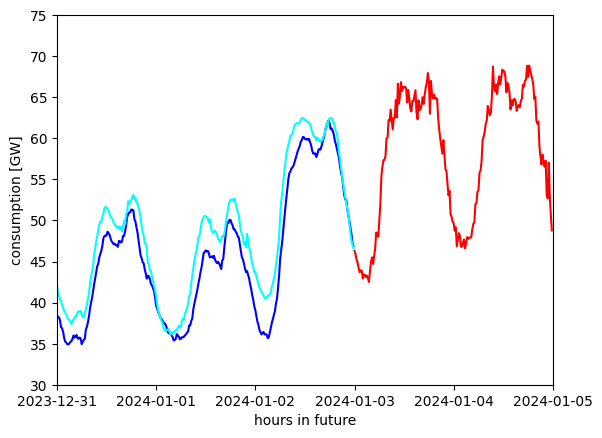

In [35]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='blue',label='observed') 
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power_pred']*4),'-',ms=1,color='cyan',label='official prediction') 
plt.plot(pred_df.date_time,pred_df.consumption*4,color='red',label='own prediction')
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")    
plt.xlim(datetime(2023, 12, 31),datetime(2024, 1, 5))
plt.ylim(30,75)

In [ ]:
Does i

[[11.         16.05557632]
 [11.25       16.3004055 ]
 [11.5        16.71058273]
 [11.75       16.44300652]
 [12.         16.55988121]
 [12.25       16.55244637]
 [12.5        16.56935883]]


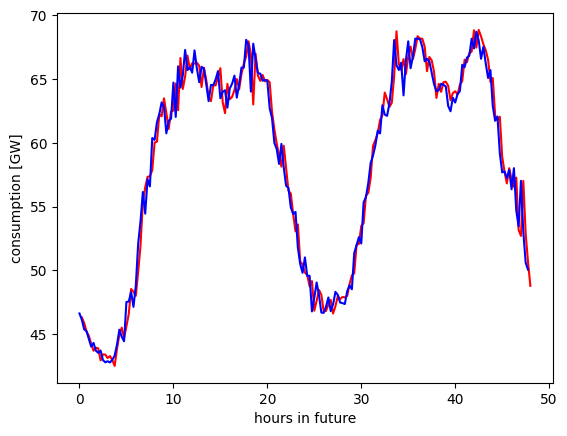

In [125]:
plt.plot(prediction[0],prediction[1]*4,color='red')
plt.plot(prediction2[0]-0.25,prediction2[1]*4,color='blue')
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")    
print(prediction[0:2,43:50].T)

LOoks plausible mostly, also not with much wiggles, but one is rather bad close to 10 hours. 
That seem to be general bad, rerun withg 20% offset regularization start. That solved the problem, others are more like noise without a clear wrong solution. 
Those wiggles are a kind of noise not really expected, whether bad depends on whether it should look better as it is or not. 

Still looks good that it can be implemented. 

## Further improvement ideas
- Need track metrics 
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points
